<a href="https://colab.research.google.com/github/YashK07/Generative-AI/blob/master/convolutional_variational_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.  [Introduction](#1)
2.  [Applications](#2)
3.  [Architecture](#3)
4.  [Properties of Autoencoder](#4)
5.  [Types of Autoencoder](#5)
6.  [Variational Autoencoder (convolutional)](#vae)
    * [Encoder implementation](#7)
    * [Latent space implementation](#8)
    * [Decoder implementation](#9)
    * [Loss Function](#10)
    * [Model layers plot](#11)
    * [Model training](#12)
    * [Model prediction](#13)
    * [Visualize  prediction](#14)
    * [Encoded dimension visualization ](#15)
    * [Decoder/Generator Model](#16)
    * [Remove Noise](#17)

<a id='1'></a>
# Autoencoder
* neural network with unsupervised machine-learning algorithm apply back-prop to set target value to the input
* auto-encoder prefers over PCA because it can learn non-linear transformations with non-linear activation functions. more efficient to learn several layer with auto-encoder then one huge transformation with PCA.

<a id='2'></a>
# Autoencoder Applications
* Image coloring (Black-white images -> colored)
* Feature variation (Extract required feature)
* Dimensionality Reduction
* Denosing image (Remove Noise)
* Remove watermark

<a id='3'></a>
# Autoencoder Architecture
* **Encoder** : part of NN compress the input into latent space representation
* **code** : part of NN represents compressed input 
* **Decoder** : Decode the encoded data to original dimension

<a id='4'></a>
# Properties of Autoencoder
1. **Data-specific**: Autoencoders are only able to meaningfully compress data similar to what they have been trained on.
2. **Lossy**: de-compressed output will be degrad compared to the original input
3. **Unsupervised**: Autoencoders are considered an unsupervised learning technique since they don’t need explicit labels to train on. But to be more precise they are **self-supervised** because they generate their own labels from the training data.

# Variational Autoencoder (convolutional)<a id="vae"></a>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.stats import norm

import tensorflow.keras as keras
from keras import backend as k
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()
k.clear_session()

In [2]:
# set parameter
image_shape = (28,28,1)
batch_size = 64
latent_dim = 2
epoch = 30

In [3]:
# import minist dataset
(x_train, y_train), (x_test,y_test) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# change datatype and reshape data
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + image_shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + image_shape)

In [5]:
# function to fatch 10 images of labeld 0 to 9
def get_images_1_to_10(x_train,y_train):
    selected_x,selected_y = [],[]
    for i in range(10):
        number_index = np.where(y_train == i)[0]
        random_index = np.random.choice(len(number_index),1,replace=False)
        select_index = number_index[random_index]
        selected_x.append(x_train[select_index[0]])
        selected_y.append(y_train[select_index][0])
    return np.array(selected_x,dtype="float32").reshape((len(selected_x),)+image_shape),np.array(selected_y,dtype="float32")

In [6]:
# select random 10 image of labeled 0 to 9
selected_x,selected_y =  get_images_1_to_10(x_train,y_train)

In [7]:
# function for plot images
def plot_image(selected_x,selected_y,title=None,save=None):
    ncols = selected_x.shape[0]
    fig,ax  = plt.subplots(nrows=1, ncols=ncols,figsize=(20,3))
    for x,y,ax_i in zip(selected_x,selected_y,ax):
        ax_i.imshow(x.reshape((28,28)))
        ax_i.axis("off")
        ax_i.set_title(int(y))
    if title:
        fig.suptitle(title)
    if save:
        fig.savefig(str(save)+".png")
    plt.show()

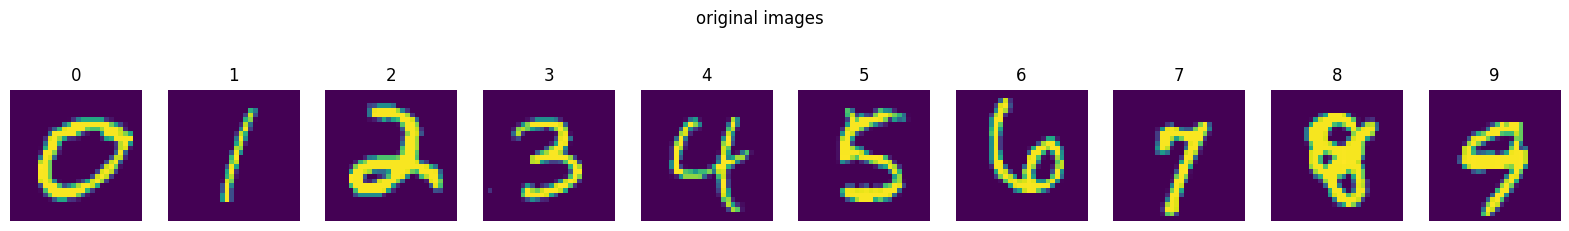

In [8]:
# plot selected images
plot_image(selected_x,selected_y,title="original images",save="original_images")

<a id='7'></a>
## Encoder implementation

In [9]:
# Input layer
# input shape = (None,28,28,1)
encoder_input = keras.Input(shape=image_shape)

# convolutional layer 1
# input shape = (None,28,28,1)
# output shape = (None,28,28,32)
conv_1 = keras.layers.Conv2D(filters=32,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(encoder_input)

# convolutional layer 2
# input shape = (None,28,28,32)
# output shape = (None,28,28,64)
conv_2 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_1)

# convolutional layer 3
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_3 = keras.layers.Conv2D(filters=64,
                             kernel_size=3,
                             padding="same",
                             activation="relu",
                            )(conv_2)

# Flatten layer
# input shape = (None,28,28,64)
# output shape = (None,50176)
flatten = keras.layers.Flatten()(conv_3)

# Dense layer 1
# input shape = (None,50176)
# output shape = (None,128)
encoder_output = keras.layers.Dense(128,activation="relu")(flatten)

<a id='8'></a>
## Latent space implementation

In [10]:
# latent mean and (log)variance

# Dense layer 2
# input shape = (None,128)
# output shape = (None,latent_dim)
z_mu = keras.layers.Dense(latent_dim)(encoder_output)

# Dense layer 3
# input shape = (None,128)
# output shape = (None,latent_dim)
z_log_sigma = keras.layers.Dense(latent_dim)(encoder_output)

In [11]:
# sampling function for latent layer
def sampling(args):
    z_mu, z_log_sigma = args

    # epsilon is simple normal distribution
    epsilon = k.random_normal(shape=(k.shape(z_mu)[0], latent_dim),mean=0., stddev=1.)
    return z_mu + k.exp(z_log_sigma) * epsilon

z = keras.layers.Lambda(sampling,output_shape=(latent_dim,))([z_mu, z_log_sigma])

\begin{equation*} Z = Z_\mu + Z_\sigma^2 \odot \varepsilon \end{equation*}

<a id='9'></a>
## Decoder implementation

In [12]:
# Dense layer 4
# input shape = (None,latent_dim)
# output shape = (None,128)
dense_2 = keras.layers.Dense(128,activation="relu")

# Dense layer 4
# input shape = (None,128)
# output shape = (None,50176)
dense_3 = keras.layers.Dense(np.prod(k.int_shape(conv_3)[1:]),
                             activation="relu"
                            )

# Reshape layer 
# input shape = (None,128)
# output shape = (None,28,28,64)
reshape = keras.layers.Reshape(k.int_shape(conv_3)[1:])

# Deconvolutional layer 1
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_4 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )
# Deconvolutional layer 2
# input shape = (None,28,28,64)
# output shape = (None,28,28,64)
conv_5 = keras.layers.Conv2DTranspose(filters=64,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# Deconvolutional layer 3
# input shape = (None,28,28,64)
# output shape = (None,28,28,32)
conv_6 = keras.layers.Conv2DTranspose(filters=32,
                                      kernel_size=3,
                                      padding="same",
                                      activation="relu"
                                     )

# convolutional layer 4
# input shape = (None,28,28,32)
# output shape = (None,28,28,1)
decoder_output = keras.layers.Conv2D(filters=1,
                                     kernel_size=3,
                                     padding="same",
                                     activation="sigmoid"
                                    )

_dense_2 = dense_2(z)
_dense_3 = dense_3(_dense_2)
_reshape = reshape(_dense_3)
_conv_4 = conv_4(_reshape)
_conv_5 = conv_5(_conv_4)
_conv_6 = conv_6(_conv_5)
_decoder_output = decoder_output(_conv_6)

## Loss Function<a id='10'></a>

In [13]:
def vae_loss(x, z_decoded):
        x = k.flatten(x)
        z_decoded = k.flatten(z_decoded)
        # Reconstruction loss
        Reconstruction_loss = 786*keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -0.5 * k.mean(1 + z_log_sigma - k.square(z_mu) - k.exp(z_log_sigma), axis=-1)
        return Reconstruction_loss + kl_loss

**Reconstruction Loss**

Reconstruction loss ensures that the input image is reconstructed at the output, and by doing so, the loss inherently mak[link text](https://)es the encoding and the decoding of VAE efficient and meaningful. The goal of VAE is to not only learn the distribution but also produce realistic-looking images similar to the training data. Hence, we need a reconstruction error function.


\begin{equation*}L_{MSE}(\theta ,\phi ) = \frac{1}{N}\sum_{i=1}^{N}{\Big(x_i -f_\theta (g_\phi (x_i))\Big)^2}                             \end{equation*}

**KL Divergence**

We train our VAE to minimize the KL divergence between the encoder’s distribution P_{\phi}(Z|X) and P(Z). In VAE, P(Z) follows a standard or unit Normal distribution ( \mu = 0 and \sigma = 1 ) or P(Z) = \mathcal{N}(0, 1). If the encoder outputs encoding Z far from a standard normal distribution, KL-divergence loss will penalize it more. The KL-divergence acts as a regularize, which keeps the encodings Z sufficiently diverse. If we omitted the regularizer, the encoder could learn to cheat and give each datapoint an encoding in a different Euclidean space region. In other words, KL divergence optimizes the probability distribution parameters \mu and \sigma to closely resemble the unit gaussian distribution \mathcal{N}(0, 1).
\begin{equation*}L_{KL}[G(Z_{\mu}, Z_{\sigma})  \|  \mathcal{N}(0, 1)]= - 0.5 * \sum_{i=1}^{N}{1 + log(Z_{\sigma_{i}}^2 - Z_{\mu_{i}}^2 -  Z_{\sigma_{i}}^2}) \end{equation*}

## Model compile and summary

In [14]:
variational_encoder = keras.Model(encoder_input,_decoder_output)
variational_encoder.compile(optimizer='rmsprop',loss=vae_loss)
variational_encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 28, 28, 64)   36928       ['conv2d_1[0][0]']               
                                                                                              

## Model plot<a id='11'></a>

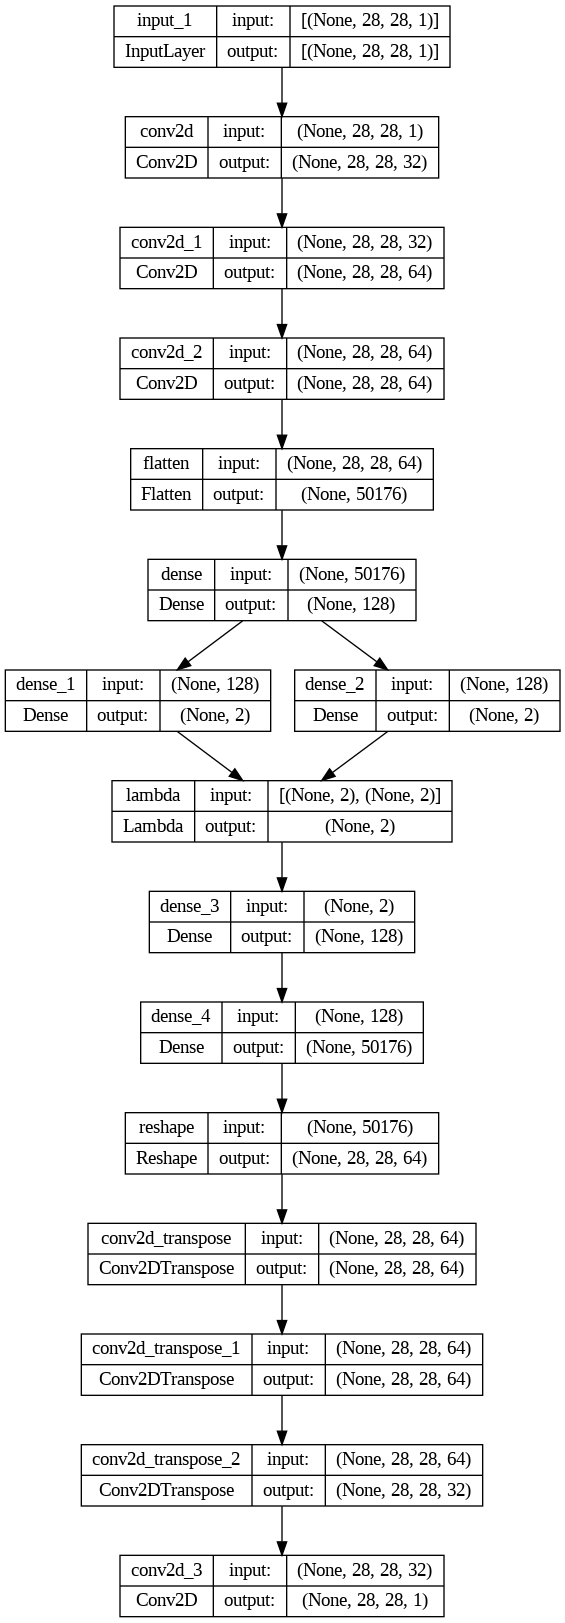

In [15]:
keras.utils.plot_model(variational_encoder,to_file="variational_encoder_L{}_E_{}.png".format(latent_dim,epoch),show_shapes=True)

## Model training<a id='12'></a>

In [16]:
variational_encoder.fit(x=x_train,y=x_train,
                        shuffle=True,
                        epochs=epoch,
                        batch_size=batch_size,
                        validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - ETA: 0s - loss: 170.4906

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 34s 574us/sample - loss: 170.4906 - val_loss: 154.7965
Epoch 2/30
60000/60000 [==============================] - 22s 364us/sample - loss: 150.0300 - val_loss: 146.2147
Epoch 3/30
60000/60000 [==============================] - 22s 365us/sample - loss: 146.0198 - val_loss: 145.6156
Epoch 4/30
60000/60000 [==============================] - 22s 366us/sample - loss: 143.8759 - val_loss: 142.2446
Epoch 5/30
60000/60000 [==============================] - 22s 362us/sample - loss: 142.4189 - val_loss: 144.5758
Epoch 6/30
60000/60000 [==============================] - 22s 364us/sample - loss: 141.5890 - val_loss: 142.3763
Epoch 7/30
60000/60000 [==============================] - 22s 366us/sample - loss: 140.8521 - val_loss: 140.5967
Epoch 8/30
60000/60000 [==============================] - 22s 365us/sample - loss: 140.3405 - val_loss: 141.9445
Epoch 9/30
60000/60000 [==============================] - 22s 363us/sample - loss: 139.9052 - val_loss: 141

In [17]:
# Model weights save
variational_encoder.save_weights('vae_L2_E10.h5')

## Model prediction<a id='13'></a>

In [20]:
pred = variational_encoder.predict(selected_x)

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [23]:
selected_x.shape

(10, 28, 28, 1)

## Visualize prediction<a id='14'></a>

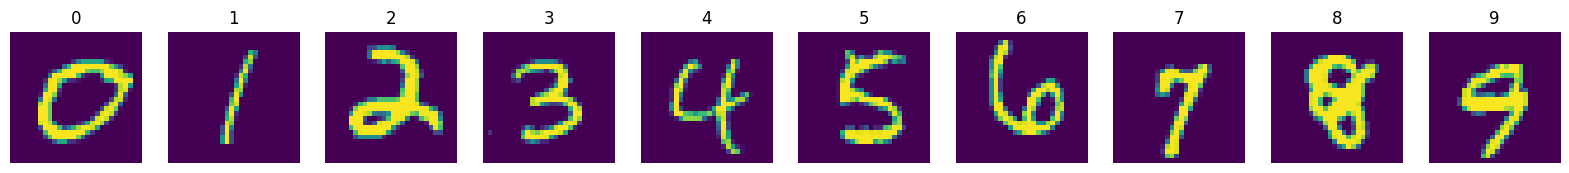

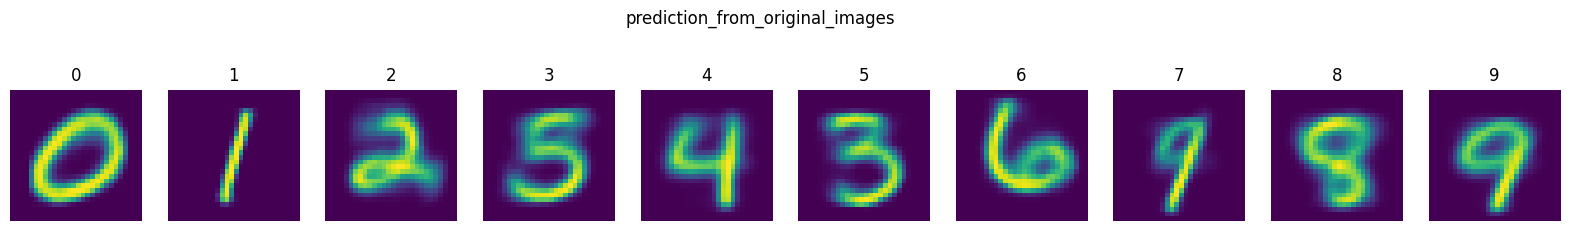

In [21]:
plot_image(selected_x,selected_y)
plot_image(pred,selected_y,title="prediction_from_original_images",save="prediction_from_original_images")

## Encoded dimension visualization <a id='15'></a>

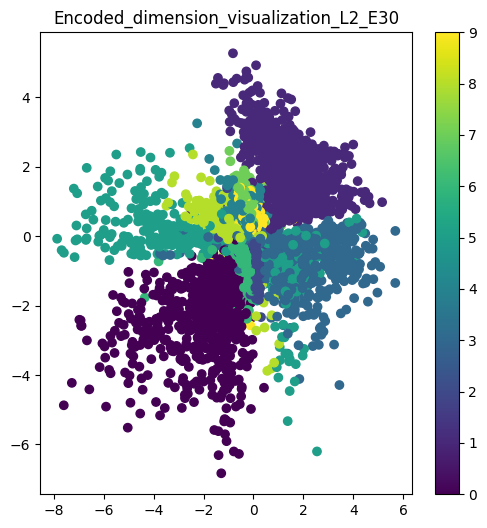

In [22]:
encoder = keras.Model(encoder_input,z_mu)
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.title("Encoded_dimension_visualization_L{}_E{}".format(latent_dim,epoch))
plt.savefig("Encoded_dimension_visualization_L{}_E{}.png".format(latent_dim,epoch))
plt.show()

# Denoising<a id="17"></a>

In [25]:
def add_noise(x, noise_factor=0.1):
    x = x + np.random.randn(*x.shape) * noise_factor
    x = x.clip(0., 1.)
    return x

In [26]:
selected_x_noisy = add_noise(selected_x)
pred_noise_remove = variational_encoder.predict(selected_x_noisy)

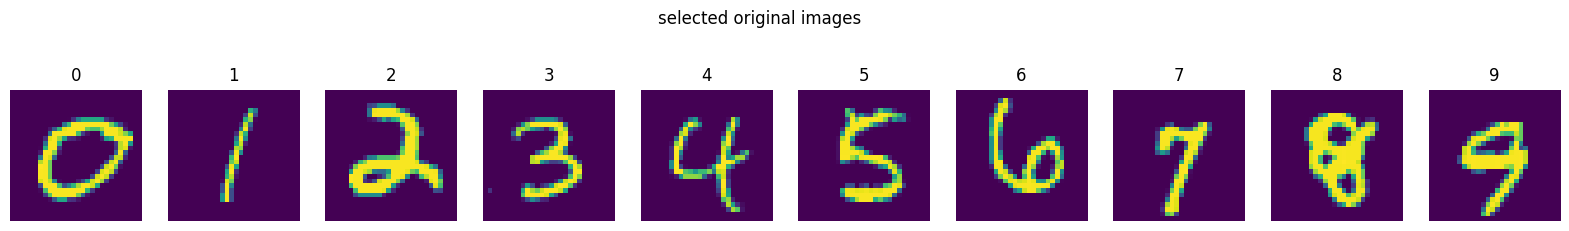

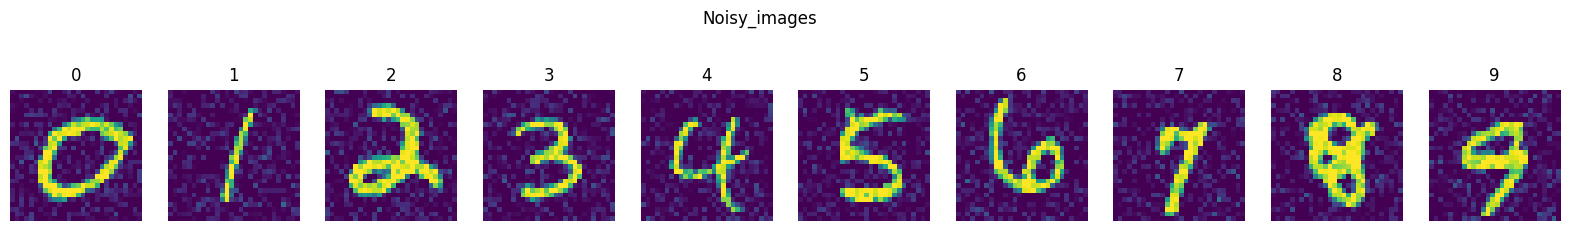

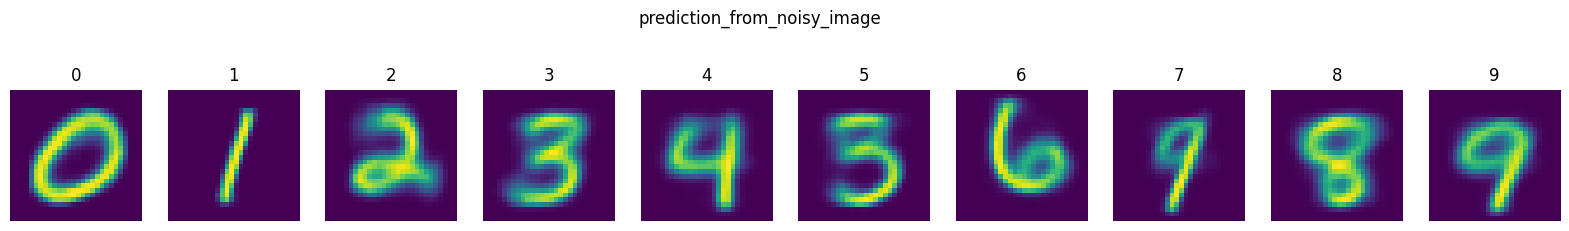

In [27]:
# selected original images
plot_image(selected_x,selected_y,title="selected original images")
# add noise to  original images
plot_image(selected_x_noisy,selected_y,title="Noisy_images",save="Noisy_images")
# predicted images from noisy image
plot_image(pred_noise_remove,selected_y,title="prediction_from_noisy_image",save="prediction_from_noisy_image")

We have trained our model to generate images for MNIST data. Now, during inference we are passing a noised image. The trained VAE architecture will predict/ or generate a denoised image through its learning.